### Student Full Name: NAVANEETH TALLURI
### Student ID: 23102357
### Email Address: tallurinavaneeth87@gmail.com

## Project Title : Enhancing Credit Card Default Prediction Using GAN-Based Data Augmentation

In [ ]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load Data Set

In [ ]:
# Load dataset & check dataset
df = pd.read_excel("/content/default of credit card clients.xls", header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# change target column name and education to education level
df.rename(columns={'default payment next month': 'default','EDUCATION': 'EDUCATION_LEVEL'}, inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION_LEVEL,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Domain Analysis from dataset provider
* Gender (1 = male; 2 = female).
* Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* Marital status (1 = married; 2 = single; 3 = others).
* default payment (Yes = 1, No = 0)

# Basic Checks

In [ ]:
# Checking data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               30000 non-null  int64
 1   LIMIT_BAL        30000 non-null  int64
 2   SEX              30000 non-null  int64
 3   EDUCATION_LEVEL  30000 non-null  int64
 4   MARRIAGE         30000 non-null  int64
 5   AGE              30000 non-null  int64
 6   PAY_0            30000 non-null  int64
 7   PAY_2            30000 non-null  int64
 8   PAY_3            30000 non-null  int64
 9   PAY_4            30000 non-null  int64
 10  PAY_5            30000 non-null  int64
 11  PAY_6            30000 non-null  int64
 12  BILL_AMT1        30000 non-null  int64
 13  BILL_AMT2        30000 non-null  int64
 14  BILL_AMT3        30000 non-null  int64
 15  BILL_AMT4        30000 non-null  int64
 16  BILL_AMT5        30000 non-null  int64
 17  BILL_AMT6        30000 non-null  int64
 18  PAY_AM

In [ ]:
# check the statistical summary
df.describe().T  # T for transposing

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION_LEVEL,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [ ]:
# Checking missing values
df.isna().sum()

,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION_LEVEL,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0


# Exploratory Data Analysis(EDA)

In [ ]:
# Check Class distribution
class_count = df['default'].value_counts()
class_count

,count
default,
0,23364
1,6636


In [ ]:
# Check Class distribution Proportion
class_count_proportion = df['default'].value_counts(normalize=True) * 100
class_count_proportion

,proportion
default,
0,77.88
1,22.12


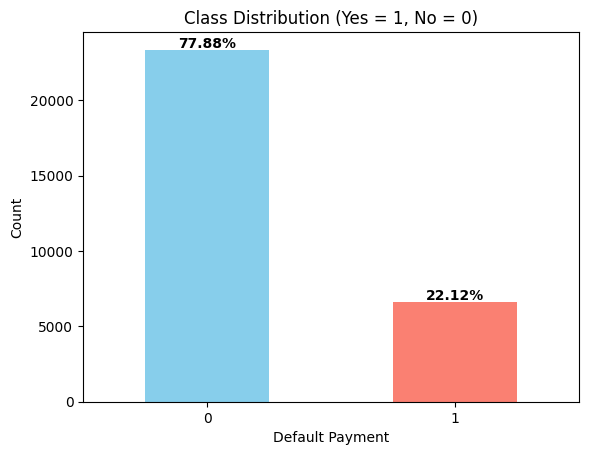

In [ ]:
# Ploting class distribution
class_count.plot(kind='bar', title='Class Distribution (Yes = 1, No = 0)',color=['skyblue', 'salmon'])

# Add proportion labels on top of bars
for i, v in enumerate(class_count):
    plt.text(i, v + 100, f"{class_count_proportion[i]:.2f}%",
             ha='center', fontsize=10, fontweight='bold')
plt.xlabel('Default Payment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

* From this class distribution above ,I can say it is **imbalance** dataset

In [ ]:
# Creating function for Univariate Histograms for numerical feature

def hist_plot(df, col):
  df[col].hist(figsize=(8,6), bins=30, color='lightsteelblue')
  plt.suptitle(f"{col} Distributions", fontsize=16)
  plt.show()

# Creating function for  Univariate Countplot for categorical feature
def count_plot(df, col):
  sns.countplot(x=col, data=df, palette='cool')
  plt.title(f"{col} Distribution")
  plt.xlabel(f"{col}")
  plt.ylabel("Count")
  plt.xticks(rotation=0)
  plt.show()

In [ ]:
# Getting columns name
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION_LEVEL', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [ ]:
# Creating new dataset copying from original to change categorical feature to categorical value from numerical

df_copy = df.copy()

# Define mapping dictionaries
sex_map = {1: 'Male', 2: 'Female'}
edu_map = {1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others', 0: 'Unknown', 5: 'Unknown', 6: 'Unknown'}
marriage_map = {1: 'Married', 2: 'Single', 3: 'Others', 0: 'Unknown'}

# Apply mapping
df_copy['SEX'] = df_copy['SEX'].map(sex_map)
df_copy['EDUCATION_LEVEL'] = df_copy['EDUCATION_LEVEL'].map(edu_map)
df_copy['MARRIAGE'] = df_copy['MARRIAGE'].map(marriage_map)


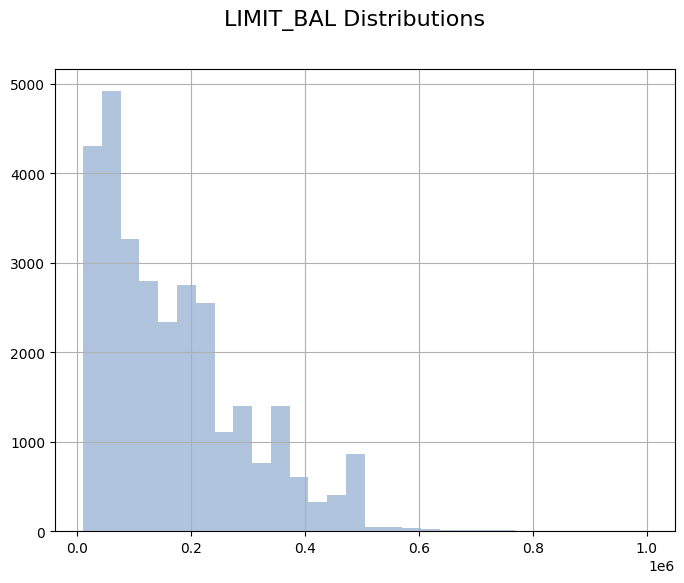

In [ ]:
# Histogram for LIMIT_BAL
hist_plot(df, "LIMIT_BAL")

* Limit balance feature is right skewed, I need to convert to normal distribution

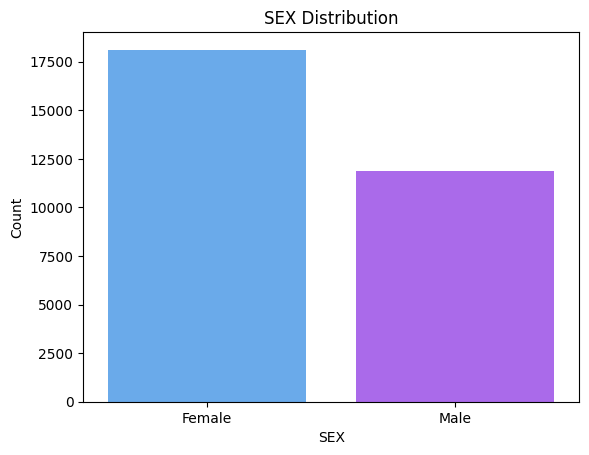

In [ ]:
# Checking SEX distribution by count plot
count_plot(df_copy, 'SEX')

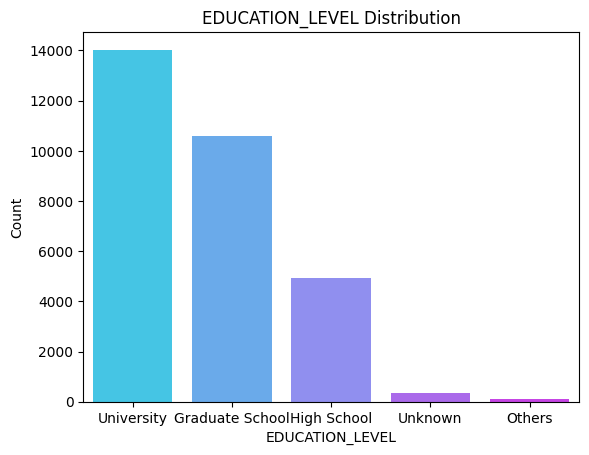

In [ ]:
# Check Education level data distribution
count_plot(df_copy, 'EDUCATION_LEVEL')

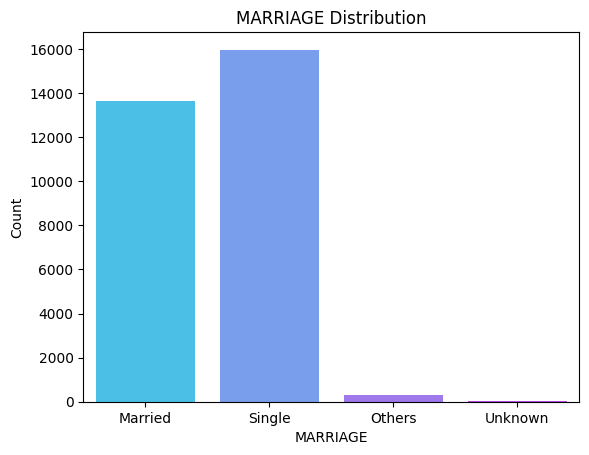

In [ ]:
# Check marriage status data distribution
count_plot(df_copy, 'MARRIAGE')

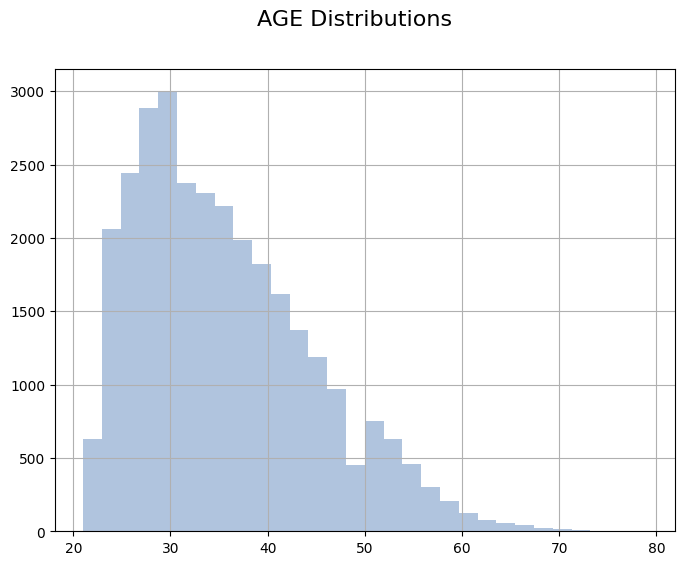

In [ ]:
# Check Age distribution
hist_plot(df, "AGE")

* Age data distribution is right skewed , I need to convert to normal distribution

In [ ]:
# Creating 3 separate dataset to see visualization for type feature together

df_delay = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
df_owed = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
df_paid = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

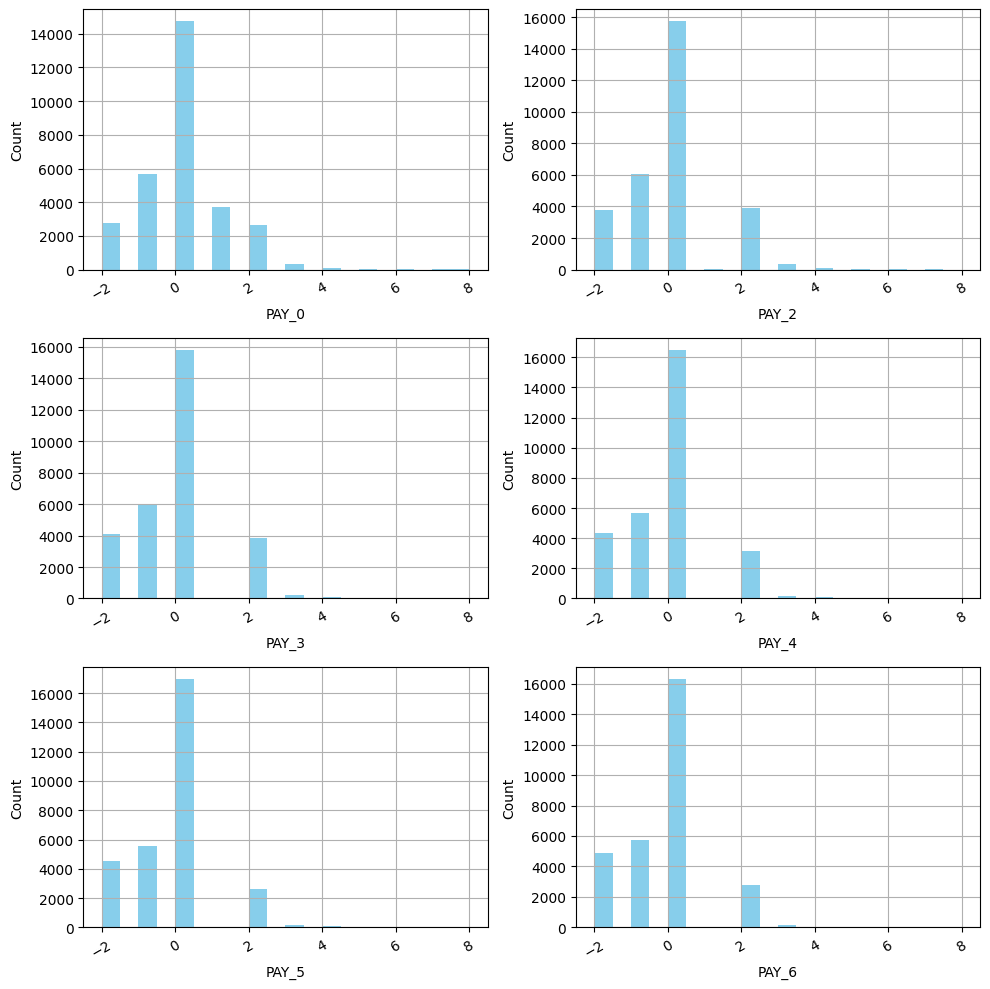

In [ ]:
# Check pay delay month of six months
plt.figure(figsize=(10, 8))
plotnumber = 1
for column in df_delay:
    if plotnumber <= 6:
        ax = plt.subplot(3, 2, plotnumber)
        df[column].hist(figsize=(10,10), bins=20, color='skyblue')
        plt.xlabel(f"{column}")
        plt.ylabel("Count")
        plt.xticks(rotation=30)
    plotnumber += 1
plt.tight_layout()
plt.show()


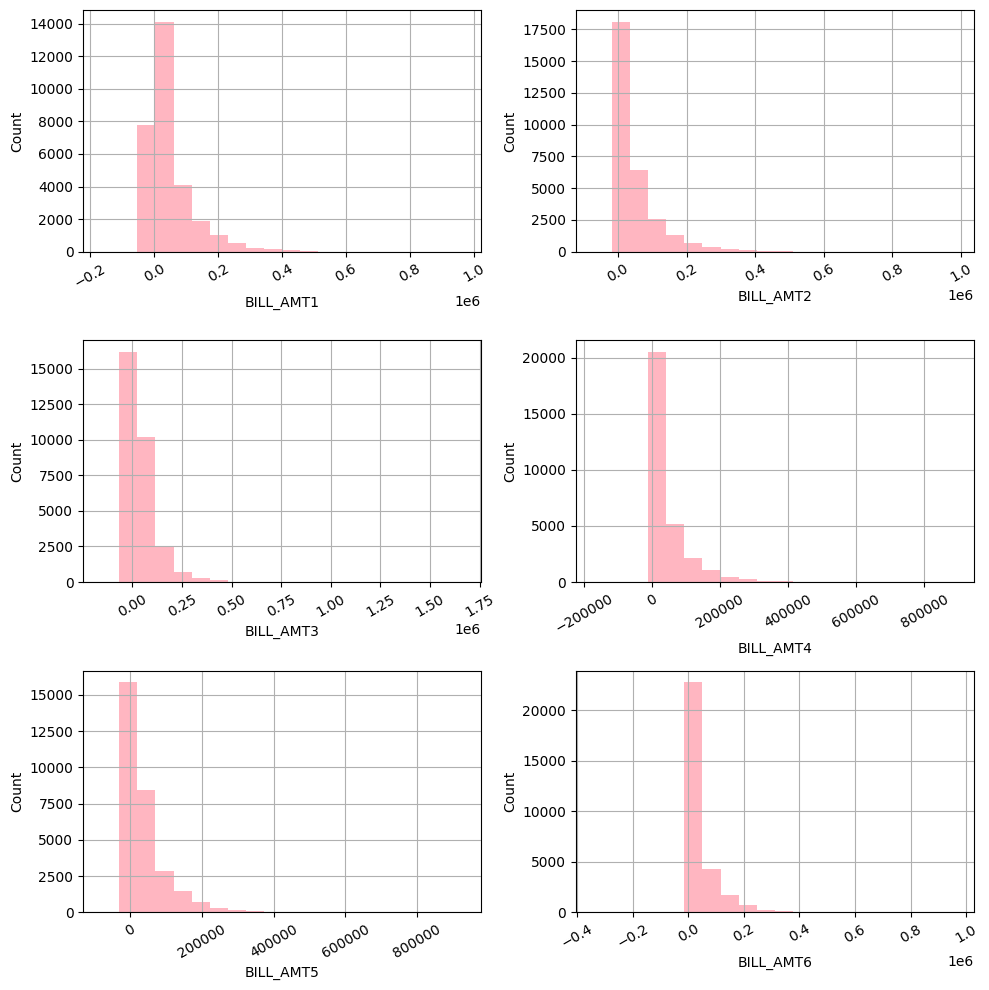

In [ ]:
# Check bill owed amount distribution of six months
plt.figure()
plotnumber = 1
for column in df_owed:
    if plotnumber <= 6:
        ax = plt.subplot(3, 2, plotnumber)
        df[column].hist(figsize=(10,10), bins=20, color='lightpink')
        plt.xlabel(f"{column}")
        plt.ylabel("Count")
        plt.xticks(rotation=30)
    plotnumber += 1
plt.tight_layout()
plt.show()

* All feature are not in same magnitude , need to do scaling

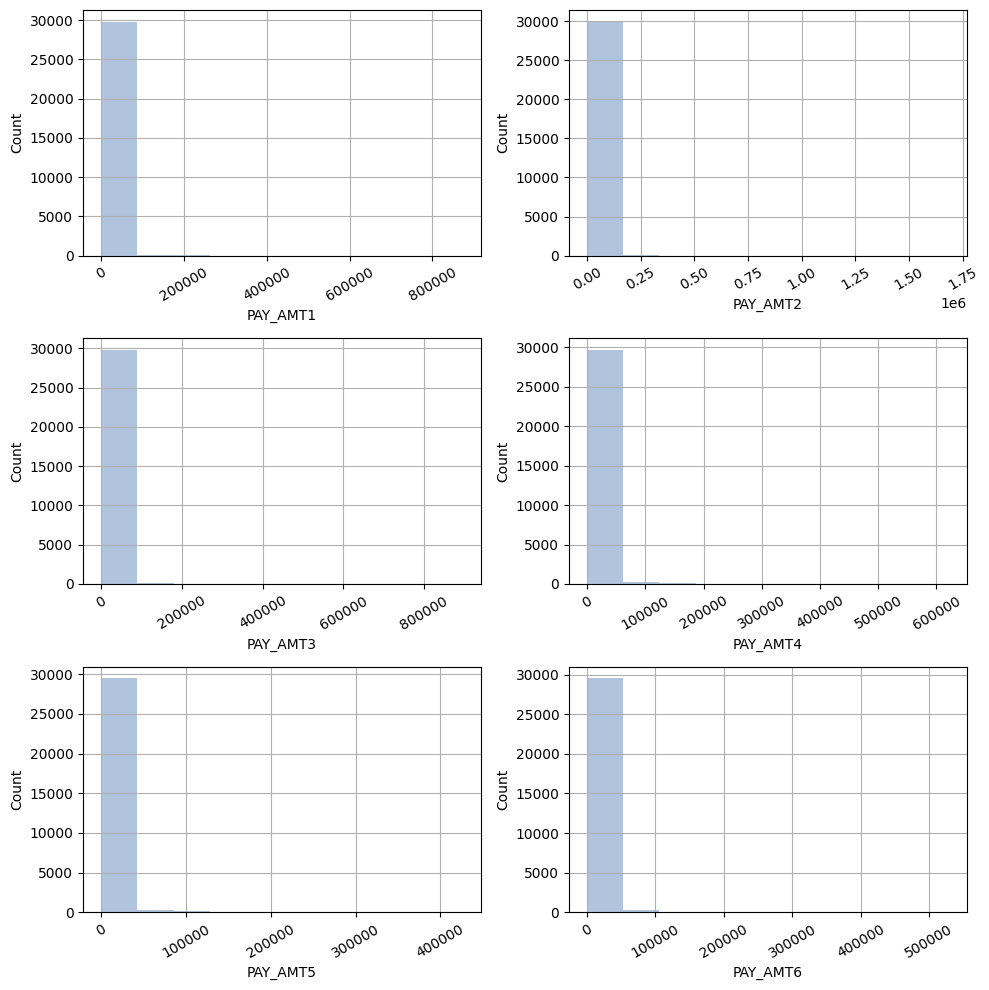

In [ ]:
# Check bill owed amount distribution of six months
plt.figure()
plotnumber = 1
for column in df_paid:
    if plotnumber <= 6:
        ax = plt.subplot(3, 2, plotnumber)
        df[column].hist(figsize=(10,10), bins=10, color='lightsteelblue')
        plt.xlabel(f"{column}")
        plt.ylabel("Count")
        plt.xticks(rotation=30)
    plotnumber += 1
plt.tight_layout()
plt.show()

* All feature are not in same magnitude , need to do scaling

### Checking correlation between default & other feature

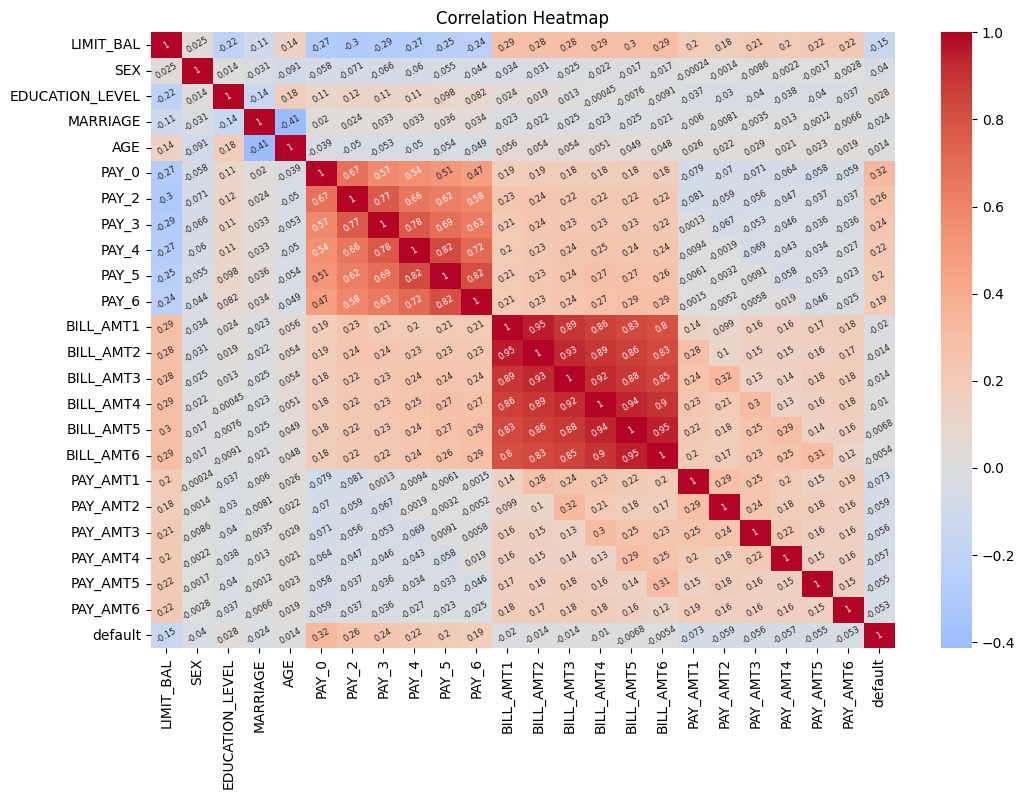

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
corr = df.drop('ID',axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', center=0,annot=True,annot_kws={"size":6, "rotation":30})
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
 # Top correlated feature with Default
corr_target = corr['default'].sort_values(ascending=False)
print("\nTop features correlated with default:")
corr_target.head(10)


Top features correlated with default:


,default
default,1.000000
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
EDUCATION_LEVEL,0.028006
AGE,0.013890
BILL_AMT6,-0.005372


# Data Preprocessing